In [4]:
from collections import defaultdict, namedtuple, Counter
import sys
import json
import numpy as np
from itertools import combinations, groupby
import scipy.stats as stats
import matplotlib.pyplot as plt
import bayesian_transmission_rate as btr


In [163]:
deletion_dir = '../deletions_ihart'
ped_file = '../data/v34.vcf.ped'

chroms = [str(x) for x in range(1, 23)]
#chroms = ['X']

In [164]:
# pull cytobands
intervals = []

with open('../data/cytoBand.txt', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0][3:] in chroms:
            intervals.append((pieces[0][3:], pieces[3], int(pieces[1]), int(pieces[2]), pieces[4]))
intervals = sorted(intervals, key=lambda x: (int(x[0]), x[2]))

interval_chroms = np.array([int(x[0]) for x in intervals])
first_chrom = [0] + np.where(interval_chroms[1:] != interval_chroms[:-1])[0].tolist()


In [165]:
# pull affected status
# (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
with open(ped_file, 'r') as f:
	for line in f:
		pieces = line.strip().split('\t')
		if len(pieces) >= 6:
			fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
			child_id_to_affected[child_id] = disease_status
			child_id_to_sex[child_id] = sex
print('ped loaded')
print('children', len(child_id_to_affected))

ped loaded
children 4611


In [166]:
Deletion = namedtuple('Deletion', ['family', 'chrom', 'start_pos', 'end_pos', 'length', 'phase_length',
                                   'opt_start_pos', 'opt_end_pos', 'trans', 'notrans', 'family_size', 
                                   'is_mat', 'is_pat', 'is_denovo', 'mother', 'father'])


In [215]:
all_deletions = []
del_to_key = lambda d: (d['family'], d['chrom'], d['start_pos'], d['end_pos'], d['is_mat'], tuple(sorted(d['trans'])), tuple(sorted(d['notrans'])))    

for chrom in chroms:
    print(chrom, end=' ')
    
    with open('%s/chr.%s.deletions.json' % (deletion_dir, chrom), 'r') as f:
        deletions = json.load(f)
    all_deletions.extend([d for d in deletions if not d['is_denovo']])
                          
                          

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

In [216]:
# filter deletions that go through the centromere
centromeres = [x for x in intervals if x[-1] == 'acen']
centromere_deletions = set()
for i, d in enumerate(all_deletions):
    for chrom, _, start_pos, end_pos, _ in centromeres:
        if d['chrom'] == chrom:
            if d['start_pos'] >= start_pos and d['start_pos'] <= end_pos:
                centromere_deletions.add(i)
            elif d['end_pos'] >= start_pos and d['end_pos'] <= end_pos:
                centromere_deletions.add(i)
            elif d['start_pos'] <= start_pos and d['end_pos'] >= end_pos:
                centromere_deletions.add(i)
print('centromere deletions', len(centromere_deletions)) 

all_deletions = [d for i, d in enumerate(all_deletions) if i not in centromere_deletions]

centromere deletions 2730


In [217]:
# remove deletions less than 100bp

#all_deletions = [d for d in all_deletions if d['length'] >= 100]

In [218]:
def find_deletion_context(deletions):
    for family, familydels in groupby(sorted(deletions, key=lambda d: d['family']), lambda d: d['family']):
        familydels = list(familydels)
        if len(familydels) == 1:
            familydels[0]['type'] = 'het'
        elif len(familydels) == 2:
            if familydels[0]['is_mat'] == familydels[1]['is_mat']:
                familydels[0]['type'] = 'double'
                familydels[1]['type'] = 'double'
            else:
                if len(set(familydels[0]['trans']) & set(familydels[1]['trans'])) > 0:
                    familydels[0]['type'] = 'doublehet'
                    familydels[1]['type'] = 'doublehet'
                else:
                    familydels[0]['type'] = 'het'
                    familydels[1]['type'] = 'het'
        elif len(familydels) == 3:
            is_mat_dels = [d for d in familydels if d['is_mat']]
            is_pat_dels = [d for d in familydels if d['is_pat']]
            if len(is_mat_dels) == 2 and len(is_pat_dels) == 1:
                is_mat_dels[0]['type'] = 'double'
                is_mat_dels[1]['type'] = 'double'
                is_pat_dels[0]['type'] = 'het'
            elif len(is_mat_dels) == 1 and len(is_pat_dels) == 2:
                is_mat_dels[0]['type'] = 'het'
                is_pat_dels[0]['type'] = 'double'
                is_pat_dels[1]['type'] = 'double'
            else:
                print('Error', familydels)
        elif len(familydels) == 4:
            familydels[0]['type'] = 'double'
            familydels[1]['type'] = 'double'
            familydels[2]['type'] = 'double'
            familydels[3]['type'] = 'double'
        else:
            print('Error', familydels)

het_deletions = set()
double_deletions = set()
doublehet_deletions = set()
for chrom in chroms:
    print(chrom, end=' ')
    
    with open('%s/chr.%s.collections.json' % (deletion_dir, chrom), 'r') as f:
        collections = json.load(f)
        
    
    for c in collections:
        find_deletion_context(c['matches'])
        for d in c['matches']:
            if d['type'] == 'double':
                double_deletions.add(del_to_key(d))
            elif d['type'] == 'het':
                het_deletions.add(del_to_key(d))
            elif d['type'] == 'doublehet':
                doublehet_deletions.add(del_to_key(d))
        

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

In [219]:
print('het', len(het_deletions))
print('double', len(double_deletions))
print('doublehet', len(doublehet_deletions))
print('het and double', len(het_deletions & double_deletions))
print('het and doublehet', len(het_deletions & doublehet_deletions))
print('double and doublehet', len(double_deletions & doublehet_deletions))
print('het and double and doublehet', len(het_deletions & double_deletions & doublehet_deletions))

het 234582
double 72773
doublehet 51549
het and double 15292
het and doublehet 17738
double and doublehet 3419
het and double and doublehet 1488


In [220]:
in_multiple = (het_deletions & double_deletions) | (het_deletions & doublehet_deletions) | (double_deletions & doublehet_deletions)

#het_only = het_deletions - doublehet_deletions - double_deletions
#doublehet_only = doublehet_deletions - double_deletions
#double_only = double_deletions

het_only = (het_deletions | doublehet_deletions) - double_deletions
double_only = double_deletions
doublehet_only = set()#doublehet_deletions - het_deletions


In [221]:
all_double_deletions = [d for d in all_deletions if del_to_key(d) in double_only]# and d['is_mat']]
all_het_deletions = [d for d in all_deletions if del_to_key(d) in het_only]# and d['is_mat']]
all_doublehet_deletions = [d for d in all_deletions if del_to_key(d) in doublehet_only]# and d['is_mat']]

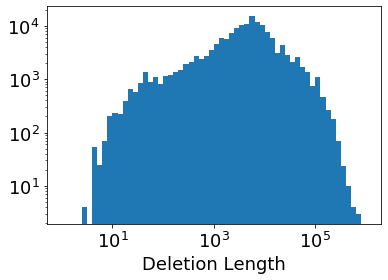

In [222]:
plt.rcParams.update({'font.size': 18})

all_lengths = [d['length'] for d in all_het_deletions]
plt.hist(all_lengths, bins=np.power(10.0, np.arange(0, 6.1, 0.1)), log=True)
plt.xscale('log')
plt.xlabel('Deletion Length')
plt.show()

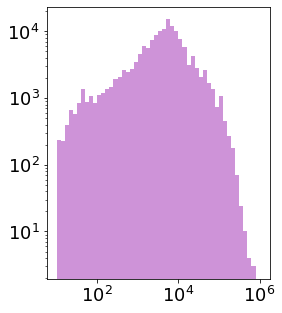

In [223]:
plt.figure(figsize=(4, 5))
all_lengths = [d['length'] for d in all_het_deletions]
plt.hist(all_lengths, bins=np.power(10.0, np.arange(1, 6.1, 0.1)), log=True, color='#ce93d8ff')
plt.xscale('log')
#plt.xlabel('Deletion Length')
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:19: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


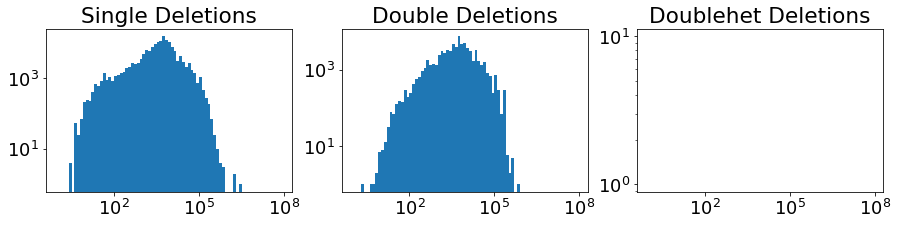

In [224]:
# lengths

plt.figure(figsize=(15, 3))

plt.subplot(1, 3, 1)
all_lengths = [d['length'] for d in all_het_deletions]
plt.hist(all_lengths, bins=np.power(10.0, np.arange(0, 8, 0.1)), log=True)
plt.xscale('log')
plt.title('Single Deletions')

plt.subplot(1, 3, 2)
all_lengths = [d['length'] for d in all_double_deletions]
plt.hist(all_lengths, bins=np.power(10.0, np.arange(0, 8, 0.1)), log=True)
plt.xscale('log')
plt.title('Double Deletions')

plt.subplot(1, 3, 3)
all_lengths = [d['length'] for d in all_doublehet_deletions]
plt.hist(all_lengths, bins=np.power(10.0, np.arange(0, 8, 0.1)), log=True)
plt.xscale('log')
plt.title('Doublehet Deletions')
plt.show()

In [225]:
# from https://stackoverflow.com/questions/22354094/pythonic-way-of-detecting-outliers-in-one-dimensional-observation-data
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

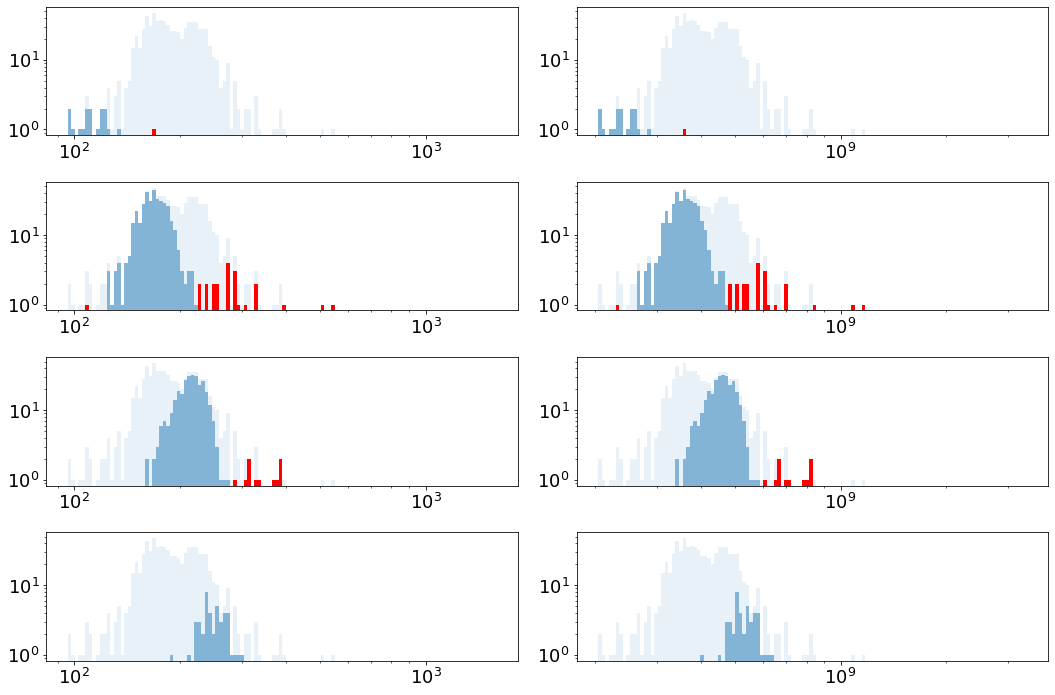

outlier families 44


In [226]:
families, family_sizes = [], []

het_total_deletions, het_total_bases = [], []
for famkey, deletions in groupby(sorted(all_het_deletions, key=lambda d: d['family']) , lambda d: d['family']):
    deletions = list(deletions)
    families.append(famkey)
    family_sizes.append(deletions[0]['family_size'])
    het_total_deletions.append(len(deletions))
    het_total_bases.append(sum([d['length'] for x in deletions]))
het_total_deletions = np.array(het_total_deletions)
het_total_bases = np.array(het_total_bases)
family_sizes = np.array(family_sizes)

#double_total_deletions, double_total_bases = [], []
#for i, (famkey, deletions) in enumerate(groupby(sorted(all_double_deletions, key=lambda d: d['family']) , lambda d: d['family'])):
#    deletions = list(deletions)
#    assert families[i] == famkey
#    double_total_deletions.append(len(deletions))
#    double_total_bases.append(sum([d['length'] for x in deletions]))
#double_total_deletions = np.array(double_total_deletions)
#double_total_bases = np.array(double_total_bases)

#doublehet_total_deletions, doublehet_total_bases = [], []
#for i, (famkey, deletions) in enumerate(groupby(sorted(all_doublehet_deletions, key=lambda d: d['family']) , lambda d: d['family'])):
#    deletions = list(deletions)
#    assert families[i] == famkey
#    doublehet_total_deletions.append(len(deletions))
#    doublehet_total_bases.append(sum([d['length'] for x in deletions]))
#doublehet_total_deletions = np.array(doublehet_total_deletions)
#doublehet_total_bases = np.array(doublehet_total_bases)
    
outlier_families = set()

plt.figure(figsize=(15, 10))
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

mi = np.log10(min(np.min(het_total_deletions), np.min(het_total_deletions)))
ma = np.log10(max(np.max(het_total_deletions), np.max(het_total_deletions)))
bins = np.power(10.0, np.arange(mi, ma, 0.01))
for i, famsize in enumerate([3, 4, 5, 6]):
    plt.subplot(4, 2, 2*i + 1)
    plt.hist(het_total_deletions, bins=bins, log=True, alpha=0.1)
    #plt.hist(double_total_deletions, bins=bins, log=True, alpha=0.1)
    #plt.hist(doublehet_total_deletions, bins=bins, log=True, alpha=0.1)
    plt.hist(het_total_deletions[family_sizes==famsize], bins=bins, log=True, alpha=0.5, color=colors[0])
    #plt.hist(double_total_deletions[family_sizes==famsize], bins=bins, log=True, alpha=0.5, color=colors[1])
    #plt.hist(doublehet_total_deletions[family_sizes==famsize], bins=bins, log=True, alpha=0.5, color=colors[2])

    families_of_this_size = [families[j] for j in np.where(family_sizes==famsize)[0]]
    outliers = mad_based_outlier(het_total_deletions[family_sizes==famsize])
    outlier_families.update([families_of_this_size[j] for j in np.where(outliers)[0]])
    plt.hist(het_total_deletions[family_sizes==famsize][outliers], bins=bins, log=True, color='red')
    #outliers = mad_based_outlier(double_total_deletions[family_sizes==famsize])
    #outlier_families.update([families_of_this_size[j] for j in np.where(outliers)[0]])
    #plt.hist(double_total_deletions[family_sizes==famsize][outliers], bins=bins, log=True, color='red')
    #outliers = mad_based_outlier(doublehet_total_deletions[family_sizes==famsize])
    #outlier_families.update([families_of_this_size[j] for j in np.where(outliers)[0]])
    #plt.hist(doublehet_total_deletions[family_sizes==famsize][outliers], bins=bins, log=True, color='red')
    plt.xscale('log')

mi = np.log10(min(np.min(het_total_bases), np.min(het_total_bases)))
ma = np.log10(max(np.max(het_total_bases), np.max(het_total_bases)))
bins = np.power(10.0, np.arange(mi, ma, 0.01))
for i, famsize in enumerate([3, 4, 5, 6]):
    plt.subplot(4, 2, 2*i + 2)
    plt.hist(het_total_bases, bins=bins, log=True, alpha=0.1)
    #plt.hist(double_total_bases, bins=bins, log=True, alpha=0.1)
    #plt.hist(doublehet_total_bases, bins=bins, log=True, alpha=0.1)
    plt.hist(het_total_bases[family_sizes==famsize], bins=bins, log=True, alpha=0.5, label=famsize, color=colors[0])
    #plt.hist(double_total_bases[family_sizes==famsize], bins=bins, log=True, alpha=0.5, label=famsize, color=colors[1])
    #plt.hist(doublehet_total_bases[family_sizes==famsize], bins=bins, log=True, alpha=0.5, label=famsize, color=colors[2])
    
    families_of_this_size = [families[j] for j in np.where(family_sizes==famsize)[0]]
    outliers = mad_based_outlier(het_total_bases[family_sizes==famsize])
    outlier_families.update([families_of_this_size[j] for j in np.where(outliers)[0]])
    plt.hist(het_total_bases[family_sizes==famsize][outliers], bins=bins, log=True, color='red')
    #outliers = mad_based_outlier(double_total_bases[family_sizes==famsize])
    #outlier_families.update([families_of_this_size[j] for j in np.where(outliers)[0]])
    #plt.hist(double_total_bases[family_sizes==famsize][outliers], bins=bins, log=True, color='red')
    #outliers = mad_based_outlier(doublehet_total_bases[family_sizes==famsize])
    #outlier_families.update([families_of_this_size[j] for j in np.where(outliers)[0]])
    #plt.hist(doublehet_total_bases[family_sizes==famsize][outliers], bins=bins, log=True, color='red')
    plt.xscale('log')

plt.tight_layout()
plt.show()

print('outlier families', len(outliers))

In [227]:
print('removing outliers het', len([d for d in all_het_deletions if d['family'] in outlier_families]),
     'double', len([d for d in all_double_deletions if d['family'] in outlier_families]),
     'doublehet', len([d for d in all_doublehet_deletions if d['family'] in outlier_families]))
all_het_deletions = [d for d in all_het_deletions if d['family'] not in outlier_families]
all_double_deletions = [d for d in all_double_deletions if d['family'] not in outlier_families]
all_doublehet_deletions = [d for d in all_doublehet_deletions if d['family'] not in outlier_families]

removing outliers het 11895 double 3375 doublehet 0


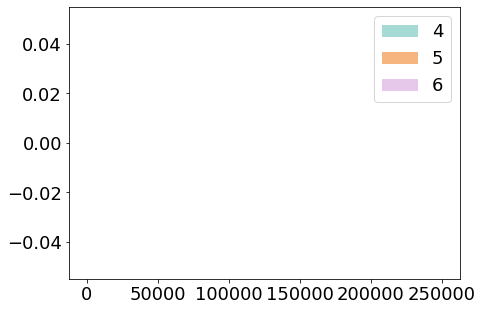

In [228]:
plt.figure(figsize=(7, 5))
bins = np.arange(0, 300000, 50000)

outlier_indices = np.array([fam in outlier_families for fam in families])
#plt.hist(het_total_bases[~outlier_indices & (family_sizes==3)], bins=bins, alpha=0.5, color='#4db6ac', label='3')
plt.hist(het_total_bases[~outlier_indices & (family_sizes==4)], bins=bins, alpha=0.5, color='#4db6ac', label='4')
plt.hist(het_total_bases[~outlier_indices & (family_sizes==5)], bins=bins, alpha=0.5, color='#ef6c00', label='5')
plt.hist(het_total_bases[~outlier_indices & (family_sizes==6)], bins=bins, alpha=0.5, color='#ce93d8ff', label='6')
plt.legend()
#plt.xticks(np.arange(1000000, 3000000, 1000000), ['%0.0e' % x for x in np.arange(1000000, 3000000, 1000000)])
plt.show()

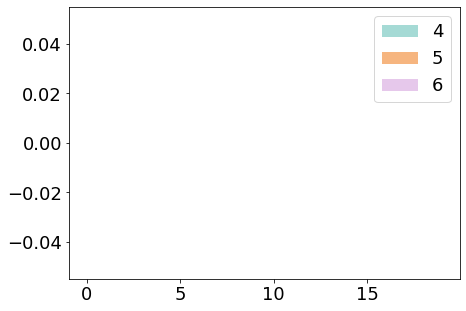

In [229]:
plt.figure(figsize=(7, 5))

#plt.hist(het_total_deletions[~outlier_indices & (family_sizes==3)], bins=np.arange(500, 1500, 50), alpha=0.5, color=, label='3')
plt.hist(het_total_deletions[~outlier_indices & (family_sizes==4)], bins=np.arange(0, 20), alpha=0.5, color='#4db6ac', label='4')
plt.hist(het_total_deletions[~outlier_indices & (family_sizes==5)], bins=np.arange(0, 20), alpha=0.5, color='#ef6c00', label='5')
plt.hist(het_total_deletions[~outlier_indices & (family_sizes==6)], bins=np.arange(0, 20), alpha=0.5, color='#ce93d8ff', label='6')
plt.legend()
plt.show()

In [230]:
child_to_bases_deleted = defaultdict(int)
child_to_deletions = defaultdict(int)

child_to_famsize = dict()
sibpairs = set()
for d in all_deletions:
    for child in d['trans']:
        child_to_bases_deleted[child] += d['length']
        child_to_deletions[child] += 1
        child_to_famsize[child] = d['family_size']
    for child1, child2 in combinations(d['trans']+d['notrans'], r=2):
        if child1 in child_id_to_affected and child2 in child_id_to_affected:
            sibpairs.add((min(child1, child2), max(child1, child2)))

In [231]:
print(len(sibpairs))

1594


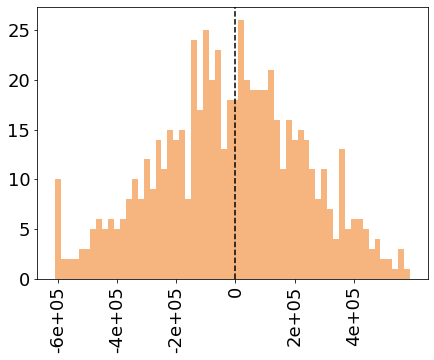

(652,)
0.495398773006135
0.8447737627933749
Ttest_indResult(statistic=0.6926558447701624, pvalue=0.48877293962327995)


In [232]:
plt.figure(figsize=(7, 5))
diff = []
for child1, child2 in sibpairs:
    if child_id_to_affected[child1] == '1' and child_id_to_affected[child2] == '2':
        diff.append(child_to_bases_deleted[child2]-child_to_bases_deleted[child1])
    elif child_id_to_affected[child1] == '2' and child_id_to_affected[child2] == '1':
        diff.append(child_to_bases_deleted[child1]-child_to_bases_deleted[child2])
diff = np.array(diff)
         
out = np.max(np.abs(diff))
plt.hist(np.clip([d for d in diff if d != 0], -600000, 600000), bins=np.arange(-610000, 610000, 20000), color='#ef6c00', alpha=0.5)
plt.axvline(0.5, color='black', linestyle='--')
plt.xticks(np.arange(-600000, 600000, 200000), ['0' if x == 0 else '%0.0e' % x for x in np.arange(-600000, 600000, 200000)], rotation=90)
plt.show()

print(diff.shape)
print(np.sum(np.array(diff)>0)/len([x for x in diff if x !=0]))
print(stats.binom_test(np.sum(np.array(diff)>0), len(diff)))
print(stats.ttest_ind(diff[diff>0], -diff[diff<0]))

-34 125


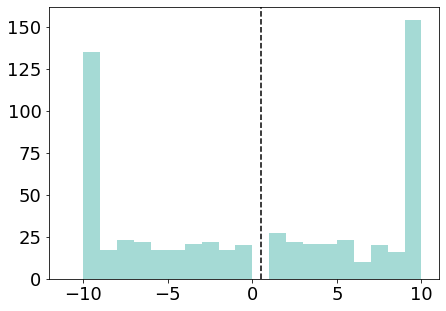

0.5024
0.36773319400323035
Ttest_indResult(statistic=0.275021480291339, pvalue=0.783390917191325)


In [233]:
plt.figure(figsize=(7, 5))

diff = []
for child1, child2 in sibpairs:
    if child_id_to_affected[child1] == '1' and child_id_to_affected[child2] == '2':
        diff.append(child_to_deletions[child2]-child_to_deletions[child1])
    elif child_id_to_affected[child1] == '2' and child_id_to_affected[child2] == '1':
        diff.append(child_to_deletions[child1]-child_to_deletions[child2])

diff = np.array(diff)
print(np.min(diff), np.max(diff))
plt.hist(np.clip(diff[diff != 0], -10, 10), bins=np.arange(-11, 11), color='#4db6ac', alpha=0.5)
plt.axvline(0.5, color='black', linestyle='--')
plt.show()

print(np.sum(np.array(diff)>0)/len(diff[diff!=0]))
print(stats.binom_test(np.sum(diff>0), len(diff)))
print(stats.ttest_ind(diff[diff>0], -diff[diff<0]))

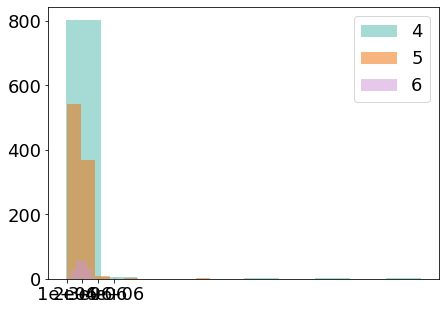

In [234]:
children = sorted(child_to_famsize.keys())
child_famsizes = np.array([child_to_famsize[x] for x in children])
child_deletions = np.array([child_to_bases_deleted[x] for x in children])

plt.figure(figsize=(7, 5))

bins = np.arange(1000000, 5000000, 100000)
#plt.hist(het_total_deletions[~outlier_indices & (family_sizes==3)], bins=np.arange(500, 1500, 50), alpha=0.5, color=, label='3')
plt.hist(child_deletions[child_famsizes==4], alpha=0.5, color='#4db6ac', label='4')
plt.hist(child_deletions[child_famsizes==5], alpha=0.5, color='#ef6c00', label='5')
plt.hist(child_deletions[child_famsizes==6], alpha=0.5, color='#ce93d8ff', label='6')
plt.xticks(np.arange(1000000, 5000000, 1000000), ['%0.0e' % x for x in np.arange(1000000, 5000000, 1000000)])

plt.legend()
plt.show()

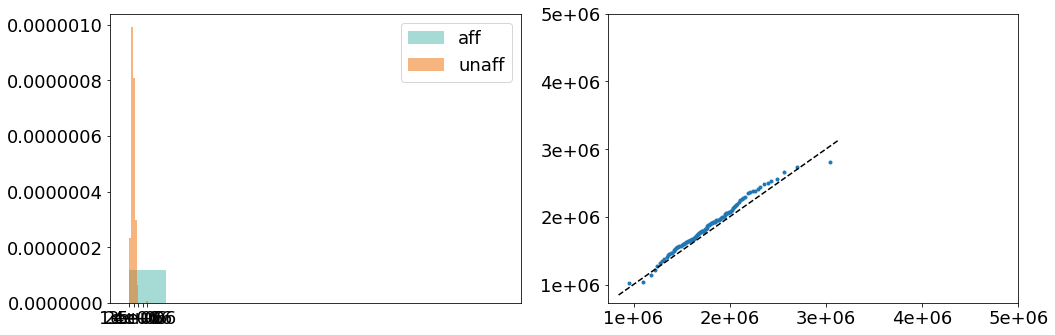

In [235]:
is_child_affected = np.array([child_id_to_affected[x] == '2' for x in children])
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
bins = np.arange(1000000, 6000000, 100000)
#plt.hist(het_total_deletions[~outlier_indices & (family_sizes==3)], bins=np.arange(500, 1500, 50), alpha=0.5, color=, label='3')
plt.hist(child_deletions[is_child_affected], alpha=0.5, density=True, color='#4db6ac', label='aff')
plt.hist(child_deletions[~is_child_affected], alpha=0.5, density=True, color='#ef6c00', label='unaff')
plt.xticks(np.arange(1000000, 6000000, 1000000), ['%0.0e' % x for x in np.arange(1000000, 6000000, 1000000)])
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(np.quantile(child_deletions[is_child_affected], np.arange(0, 1, 0.01)),
           np.quantile(child_deletions[~is_child_affected], np.arange(0, 1, 0.01)), marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.xticks(np.arange(1000000, 6000000, 1000000), ['%0.0e' % x for x in np.arange(1000000, 6000000, 1000000)])
plt.yticks(np.arange(1000000, 6000000, 1000000), ['%0.0e' % x for x in np.arange(1000000, 6000000, 1000000)])

plt.tight_layout()
plt.show()

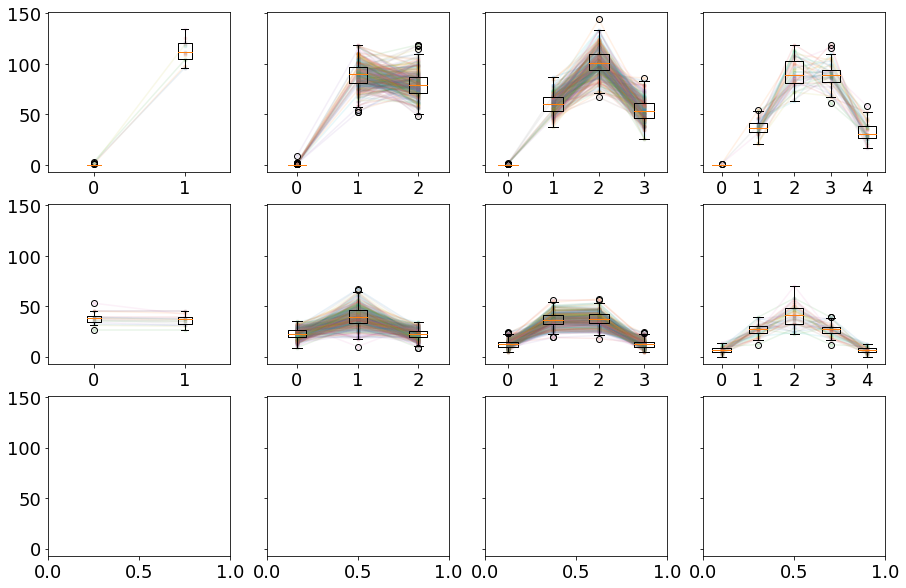

In [236]:
# check inheritance outliers

fig, splts = plt.subplots(3, 4, figsize=(15, 10), sharey=True)
boxplots = [[], [], [], []]
for famkey, deletions in groupby(sorted(all_het_deletions, key=lambda d: d['family']) , lambda d: d['family']):
    deletions = list(deletions)
    famsize = deletions[0]['family_size']-3
    vs, cs = np.unique(np.array([len(d['trans']) for d in deletions]), return_counts=True)
    splts[0, famsize].plot(vs, cs, alpha=0.1, marker='.')
    v_to_c = dict(zip(vs, cs))
    boxplots[famsize].append([0 if i not in v_to_c else v_to_c[i] for i in range(famsize+2)])
    
for i, boxplot in enumerate(boxplots):
    splts[0, i].boxplot(np.array(boxplot), positions=range(i+2))
    
boxplots = [[], [], [], []]
for famkey, deletions in groupby(sorted(all_double_deletions, key=lambda d: d['family']) , lambda d: d['family']):
    deletions = list(deletions)
    famsize = deletions[0]['family_size']-3
    vs, cs = np.unique(np.array([len(d['trans']) for d in deletions]), return_counts=True)
    splts[1, famsize].plot(vs, cs, alpha=0.1, marker='.')
    v_to_c = dict(zip(vs, cs))
    boxplots[famsize].append([0 if i not in v_to_c else v_to_c[i] for i in range(famsize+2)])
    
for i, boxplot in enumerate(boxplots):
    splts[1, i].boxplot(np.array(boxplot), positions=range(i+2))

#boxplots = [[], [], [], []]
#for famkey, deletions in groupby(sorted(all_doublehet_deletions, key=lambda d: d['family']) , lambda d: d['family']):
#    deletions = list(deletions)
#    famsize = deletions[0]['family_size']-3
#    vs, cs = np.unique(np.array([len(d['trans']) for d in deletions]), return_counts=True)
#    splts[2, famsize].plot(vs, cs, alpha=0.1, marker='.')
#    v_to_c = dict(zip(vs, cs))
#    boxplots[famsize].append([0 if i not in v_to_c else v_to_c[i] for i in range(i+2)])
#    
#for i, boxplot in enumerate(boxplots):
#    splts[2, i].boxplot(np.array(boxplot), positions=range(1, i+2))

plt.show()

In [237]:
#afs = []
#very_rare_deletions = set()
#rare_deletions = set()
#low_freq_deletions = set()
#
#for chrom in chroms:
#    print(chrom, end=' ')
#    
#    with open('%s/chr.%s.collections.json' % (deletion_dir, chrom), 'r') as f:
#        collections = json.load(f)
#    
#    afs.extend([len(c['matches']) for c in collections])
#    
#    for c in collections:
#        if len(c['matches']) < 100:
#            low_freq_deletions.update([del_to_key(d) for d in c['matches']])
#            
#            if len(c['matches']) < 10:
#                rare_deletions.update([del_to_key(d) for d in c['matches']])
#                
#                if len(c['matches']) == 1:
#                    very_rare_deletions.update([del_to_key(d) for d in c['matches']])
#                    
#print(len(low_freq_deletions), len(rare_deletions), len(very_rare_deletions))

In [238]:
#plt.hist(np.clip(afs, None, 200), log=True, bins=np.arange(201))
#plt.show()

# Overall deletion transmission

In [239]:
grid = np.arange(0.0001, 1, 0.0001)

def estimate_transmission(vs, counts, doublehet_vs, doublehet_counts,
                          max_iters=5, l1_convergence_cutoff=np.power(10.0, -2)):
    prior = stats.beta.pdf(grid, 2, 2)

    prev_ps = None
    ps = np.array([0.5 for _ in range(vs.shape[1])])
    diff = 1
    num_iters = 0
    
    while diff>l1_convergence_cutoff and num_iters<max_iters:
        # start with our prior
        posteriors = np.array([np.log(prior) for _ in range(vs.shape[1])]).T
        
        # for each deletion
        for i in range(vs.shape[0]):
            # if the deletion is transmitted
            if np.sum(vs[i, :, 1]) > 0:
                ns = np.sum(vs[i, :, :], axis=1)
                has_data = ns > 0

                # form p_nt
                p_nt = np.ones(posteriors.shape)
                for index1 in np.where(has_data)[0]:
                    for index2 in np.where(has_data)[0]:
                        if index1 == index2:
                            p_nt[:, index1] = p_nt[:, index1] * np.power(1-grid, ns[index2])
                        else:
                            p_nt[:, index1] = p_nt[:, index1] * np.power(1-ps[index2], ns[index2])

                assert np.all(p_nt[:, has_data] < 1)
                assert np.all(p_nt[:, has_data] > 0)
                posteriors[:, has_data] -= counts[i] * np.log(1-p_nt[:, has_data])

                # now form likelihood
                for index1 in np.where(has_data)[0]:
                    for index2 in np.where(has_data)[0]:
                        if index1==index2:
                            posteriors[:, index1] += counts[i] * ((vs[i, index2, 1] * np.log(grid)) + (vs[i, index2, 0] * np.log(1-grid)))
                        else:
                            posteriors[:, index1] += counts[i] * ((vs[i, index2, 1] * np.log(ps[index2])) + (vs[i, index2, 0] * np.log(1-ps[index2])))

        ## for each doublehet deletion
        #for i in range(doublehet_vs.shape[0]):
        #    ns = np.sum(doublehet_vs[i, :, :], axis=1)
        #    has_data = ns > 0
       # 
        #    # form p_ndt
        #    p_ndt = np.ones(posteriors.shape)
        #    for index1 in np.where(has_data)[0]:
        #        for index2 in np.where(has_data)[0]:
        #            if index1 == index2:
        #                p_ndt[:, index1] = p_ndt[:, index1] * np.power(1-np.power(grid, 2), ns[index2])
        #            else:
        #                p_ndt[:, index1] = p_ndt[:, index1] * np.power(1-np.power(ps[index2], 2), ns[index2])
       # 
       #     assert np.all(p_ndt[:, has_data] < 1)
       #     assert np.all(p_ndt[:, has_data] > 0)
       #     posteriors[:, has_data] -= doublehet_counts[i] * 0.5 * np.log(1-p_ndt[:, has_data])
       # 
       #     # now form likelihood
       #     for index1 in np.where(has_data)[0]:
       #         for index2 in np.where(has_data)[0]:
       #             if index1==index2:
       #                 posteriors[:, index1] += doublehet_counts[i] * ((doublehet_vs[i, index2, 1] * np.log(grid)) + (doublehet_vs[i, index2, 0] * np.log(1-grid)))
       #             else:
       #                 posteriors[:, index1] += doublehet_counts[i] * ((doublehet_vs[i, index2, 1] * np.log(ps[index2])) + (doublehet_vs[i, index2, 0] * np.log(1-ps[index2])))

        # switch back to probability space
        for index in range(vs.shape[1]):
            posteriors[:, index] = np.exp(posteriors[:, index] - np.max(posteriors[:, index]))
            posteriors[:, index] = posteriors[:, index]/np.sum(posteriors[:, index])
         
        # check convergence
        ps = np.array([np.mean(grid.shape[0]*grid*posteriors[:, i]) for i in range(vs.shape[1])])
        assert np.all(ps>0) & np.all(ps<1)
        diff = 1 if prev_ps is None else np.sum(np.abs(ps-prev_ps))
        prev_ps = ps
        num_iters += 1

    #if diff>l1_convergence_cutoff:
    #	print('did not converge')
    #	#posteriors[:] = np.nan
    #	#ps = [np.nan, np.nan, np.nan, np.nan]

    return posteriors, ps, diff


In [240]:
# deletion, AM/AF/UM/UF, notrans/trans
family_transmission = np.zeros((len(all_het_deletions), 4, 2), dtype=int)
for i, d in enumerate(all_het_deletions):
    family_transmission[i, 0, 0] = len([x for x in d['notrans'] if child_id_to_sex[x] == '1' and child_id_to_affected[x] == '2'])
    family_transmission[i, 0, 1] = len([x for x in d['trans'] if child_id_to_sex[x] == '1' and child_id_to_affected[x] == '2'])

    family_transmission[i, 1, 0] = len([x for x in d['notrans'] if child_id_to_sex[x] == '2' and child_id_to_affected[x] == '2'])
    family_transmission[i, 1, 1] = len([x for x in d['trans'] if child_id_to_sex[x] == '2' and child_id_to_affected[x] == '2'])

    family_transmission[i, 2, 0] = len([x for x in d['notrans'] if child_id_to_sex[x] == '1' and child_id_to_affected[x] == '1'])
    family_transmission[i, 2, 1] = len([x for x in d['trans'] if child_id_to_sex[x] == '1' and child_id_to_affected[x] == '1'])

    family_transmission[i, 3, 0] = len([x for x in d['notrans'] if child_id_to_sex[x] == '2' and child_id_to_affected[x] == '1'])
    family_transmission[i, 3, 1] = len([x for x in d['trans'] if child_id_to_sex[x] == '2' and child_id_to_affected[x] == '1'])

vs, cs = np.unique(family_transmission, axis=0, return_counts=True)

family_transmission = np.zeros((len(all_doublehet_deletions), 4, 2), dtype=int)
for i, d in enumerate(all_doublehet_deletions):
    family_transmission[i, 0, 0] = len([x for x in d['notrans'] if child_id_to_sex[x] == '1' and child_id_to_affected[x] == '2'])
    family_transmission[i, 0, 1] = len([x for x in d['trans'] if child_id_to_sex[x] == '1' and child_id_to_affected[x] == '2'])

    family_transmission[i, 1, 0] = len([x for x in d['notrans'] if child_id_to_sex[x] == '2' and child_id_to_affected[x] == '2'])
    family_transmission[i, 1, 1] = len([x for x in d['trans'] if child_id_to_sex[x] == '2' and child_id_to_affected[x] == '2'])

    family_transmission[i, 2, 0] = len([x for x in d['notrans'] if child_id_to_sex[x] == '1' and child_id_to_affected[x] == '1'])
    family_transmission[i, 2, 1] = len([x for x in d['trans'] if child_id_to_sex[x] == '1' and child_id_to_affected[x] == '1'])

    family_transmission[i, 3, 0] = len([x for x in d['notrans'] if child_id_to_sex[x] == '2' and child_id_to_affected[x] == '1'])
    family_transmission[i, 3, 1] = len([x for x in d['trans'] if child_id_to_sex[x] == '2' and child_id_to_affected[x] == '1'])

print(np.sum(np.any(family_transmission > 0, axis=(1, 2))))

#doublehet_vs, doublehet_cs = np.unique(family_transmission, axis=0, return_counts=True)
doublehet_vs, doublehet_cs = None, None
posteriors, ps, diff = estimate_transmission(vs, cs, doublehet_vs, doublehet_cs, max_iters=10)


0


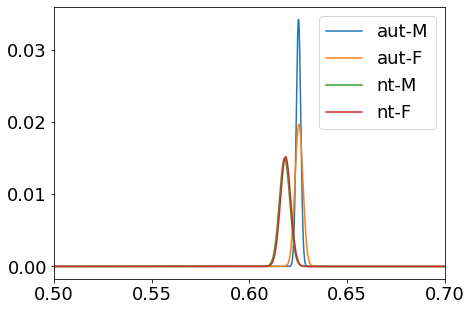

M 0.056878720874127105
F 0.13992866156705652
Combined (9.666913056732701, 0.04642826632552755)
aff 0.7346411672973917
unaff 0.91778804575043
Combined (0.7883238174848248, 0.9400065306195959)


In [241]:
plt.figure(figsize=(7, 5))
labels = ['aut-M', 'aut-F', 'nt-M', 'nt-F']
for i in range(4):
    plt.plot(grid, posteriors[:, i], label=labels[i])
plt.xlim([0.5, 0.7])
plt.legend()
plt.show()

m_pvalue = np.sum(np.minimum(posteriors[:, 0], posteriors[:, 2]))/np.sum(posteriors[:, 0])
f_pvalue = np.sum(np.minimum(posteriors[:, 1], posteriors[:, 3]))/np.sum(posteriors[:, 1])
print('M', m_pvalue)
print('F', f_pvalue)
print('Combined', stats.combine_pvalues([m_pvalue, f_pvalue]))

aff_pvalue = np.sum(np.minimum(posteriors[:, 0], posteriors[:, 1]))/np.sum(posteriors[:, 0])
unaff_pvalue = np.sum(np.minimum(posteriors[:, 2], posteriors[:, 3]))/np.sum(posteriors[:, 2])
print('aff', aff_pvalue)
print('unaff', unaff_pvalue)
print('Combined', stats.combine_pvalues([aff_pvalue, unaff_pvalue]))

In [242]:
# deletion, AM/AF/UM/UF, notrans/trans
family_transmission = np.zeros((len(all_het_deletions), 8, 2), dtype=int)
for i, d in enumerate(all_het_deletions):
    if d['is_mat']:
        family_transmission[i, 0, 0] = len([x for x in d['notrans'] if child_id_to_sex[x] == '1' and child_id_to_affected[x] == '2'])
        family_transmission[i, 0, 1] = len([x for x in d['trans'] if child_id_to_sex[x] == '1' and child_id_to_affected[x] == '2'])

        family_transmission[i, 1, 0] = len([x for x in d['notrans'] if child_id_to_sex[x] == '2' and child_id_to_affected[x] == '2'])
        family_transmission[i, 1, 1] = len([x for x in d['trans'] if child_id_to_sex[x] == '2' and child_id_to_affected[x] == '2'])

        family_transmission[i, 2, 0] = len([x for x in d['notrans'] if child_id_to_sex[x] == '1' and child_id_to_affected[x] == '1'])
        family_transmission[i, 2, 1] = len([x for x in d['trans'] if child_id_to_sex[x] == '1' and child_id_to_affected[x] == '1'])

        family_transmission[i, 3, 0] = len([x for x in d['notrans'] if child_id_to_sex[x] == '2' and child_id_to_affected[x] == '1'])
        family_transmission[i, 3, 1] = len([x for x in d['trans'] if child_id_to_sex[x] == '2' and child_id_to_affected[x] == '1'])
    else:
        family_transmission[i, 4, 0] = len([x for x in d['notrans'] if child_id_to_sex[x] == '1' and child_id_to_affected[x] == '2'])
        family_transmission[i, 4, 1] = len([x for x in d['trans'] if child_id_to_sex[x] == '1' and child_id_to_affected[x] == '2'])

        family_transmission[i, 5, 0] = len([x for x in d['notrans'] if child_id_to_sex[x] == '2' and child_id_to_affected[x] == '2'])
        family_transmission[i, 5, 1] = len([x for x in d['trans'] if child_id_to_sex[x] == '2' and child_id_to_affected[x] == '2'])

        family_transmission[i, 6, 0] = len([x for x in d['notrans'] if child_id_to_sex[x] == '1' and child_id_to_affected[x] == '1'])
        family_transmission[i, 6, 1] = len([x for x in d['trans'] if child_id_to_sex[x] == '1' and child_id_to_affected[x] == '1'])

        family_transmission[i, 7, 0] = len([x for x in d['notrans'] if child_id_to_sex[x] == '2' and child_id_to_affected[x] == '1'])
        family_transmission[i, 7, 1] = len([x for x in d['trans'] if child_id_to_sex[x] == '2' and child_id_to_affected[x] == '1'])

vs, cs = np.unique(family_transmission, axis=0, return_counts=True)

#doublehet_vs, doublehet_cs = np.unique(family_transmission, axis=0, return_counts=True)
doublehet_vs, doublehet_cs = None, None
posteriors, ps, diff = estimate_transmission(vs, cs, doublehet_vs, doublehet_cs, max_iters=10)


[0.62115051 0.62680005 0.62061699 0.62008857 0.62921116 0.62411896
 0.61553449 0.61717297] 0.004154861046971714


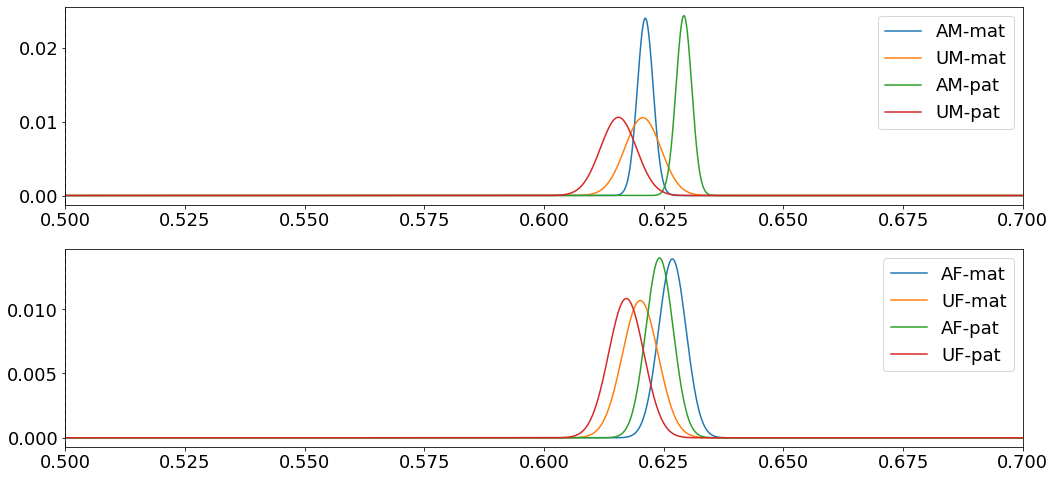

0.6178565625069197 0.3064235711696073 0.010347207797443704 0.28528952650394773
Mat (10.10507504331846, 0.0386944185646605)
Pat (4.874075293145559, 0.3004638909540295)
All (14.979150336464018, 0.0595521386035564)


In [243]:
plt.figure(figsize=(15, 7))
labels = ['AM-mat', 'AF-mat', 'UM-mat', 'UF-mat', 'AM-pat', 'AF-pat', 'UM-pat', 'UF-pat']
print(ps, diff)

plt.subplot(2, 1, 1)
for i in range(0, 8, 2):
    plt.plot(grid, posteriors[:, i], label=labels[i])
plt.xlim([0.5, 0.7])
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()

plt.subplot(2, 1, 2)
for i in range(1, 8, 2):
    plt.plot(grid, posteriors[:, i], label=labels[i])
plt.xlim([0.5, 0.7])
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()

plt.tight_layout()
plt.show()

m_mat_pvalue = np.sum(np.minimum(posteriors[:, 0], posteriors[:, 2]))/np.sum(posteriors[:, 0])
m_pat_pvalue = np.sum(np.minimum(posteriors[:, 1], posteriors[:, 3]))/np.sum(posteriors[:, 1])
f_mat_pvalue = np.sum(np.minimum(posteriors[:, 4], posteriors[:, 6]))/np.sum(posteriors[:, 4])
f_pat_pvalue = np.sum(np.minimum(posteriors[:, 5], posteriors[:, 7]))/np.sum(posteriors[:, 5])
print(m_mat_pvalue, m_pat_pvalue, f_mat_pvalue, f_pat_pvalue)

print('Mat', stats.combine_pvalues([m_mat_pvalue, f_mat_pvalue]))
print('Pat', stats.combine_pvalues([m_pat_pvalue, f_pat_pvalue]))
print('All', stats.combine_pvalues([m_mat_pvalue, f_mat_pvalue, m_pat_pvalue, f_pat_pvalue]))



In [244]:
# deletion, AM/AF/UM/UF, notrans/trans
family_transmission = np.zeros((len(all_het_deletions), 4, 2), dtype=int)
for i, d in enumerate(all_het_deletions):
    if d['is_mat']:
        family_transmission[i, 0, 0] = len([x for x in d['notrans'] if child_id_to_affected[x] == '2'])
        family_transmission[i, 0, 1] = len([x for x in d['trans'] if child_id_to_affected[x] == '2'])

        family_transmission[i, 1, 0] = len([x for x in d['notrans'] if child_id_to_affected[x] == '1'])
        family_transmission[i, 1, 1] = len([x for x in d['trans'] if child_id_to_affected[x] == '1'])

    else:
        family_transmission[i, 2, 0] = len([x for x in d['notrans'] if child_id_to_affected[x] == '2'])
        family_transmission[i, 2, 1] = len([x for x in d['trans'] if child_id_to_affected[x] == '2'])

        family_transmission[i, 3, 0] = len([x for x in d['notrans'] if child_id_to_affected[x] == '1'])
        family_transmission[i, 3, 1] = len([x for x in d['trans'] if child_id_to_affected[x] == '1'])
        
vs, cs = np.unique(family_transmission, axis=0, return_counts=True)

#doublehet_vs, doublehet_cs = np.unique(family_transmission, axis=0, return_counts=True)
doublehet_vs, doublehet_cs = None, None
posteriors, ps, diff = estimate_transmission(vs, cs, doublehet_vs, doublehet_cs, max_iters=10)


[0.62243753 0.62014398 0.62805562 0.61611545] 0.005558865337786378


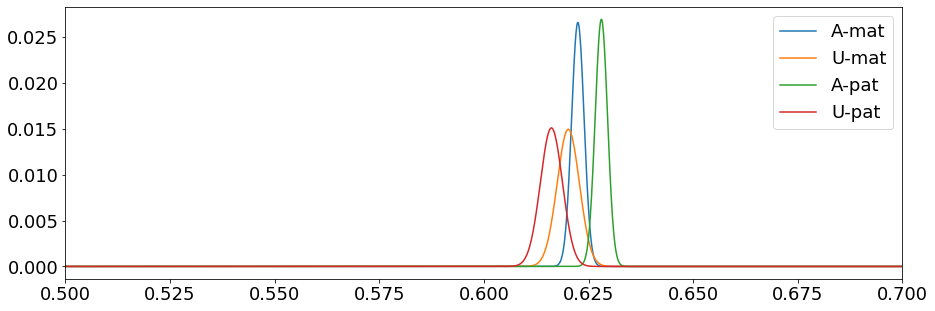

mat 0.534934020432719
pat 0.0035649007418054462


In [245]:
print(ps, diff)
plt.figure(figsize=(15, 5))
labels = ['A-mat', 'U-mat', 'A-pat', 'U-pat']
for i in range(4):
    plt.plot(grid, posteriors[:, i], label=labels[i])
plt.xlim([0.5, 0.7])
plt.legend()
plt.show()

print('mat', np.sum(np.minimum(posteriors[:, 0], posteriors[:, 1]))/np.sum(posteriors[:, 0]))
print('pat', np.sum(np.minimum(posteriors[:, 2], posteriors[:, 3]))/np.sum(posteriors[:, 2]))

In [246]:
# deletion, AM/AF/UM/UF, notrans/trans
family_transmission = np.zeros((len(all_het_deletions), 2, 2), dtype=int)
for i, d in enumerate(all_het_deletions):
    family_transmission[i, 0, 0] = len([x for x in d['notrans'] if child_id_to_affected[x] == '2'])
    family_transmission[i, 0, 1] = len([x for x in d['trans'] if child_id_to_affected[x] == '2'])

    family_transmission[i, 1, 0] = len([x for x in d['notrans'] if child_id_to_affected[x] == '1'])
    family_transmission[i, 1, 1] = len([x for x in d['trans'] if child_id_to_affected[x] == '1'])

vs, cs = np.unique(family_transmission, axis=0, return_counts=True)
print(np.sum(np.any(family_transmission > 0, axis=(1, 2))))

family_transmission = np.zeros((len(all_doublehet_deletions), 2, 2), dtype=int)
for i, d in enumerate(all_doublehet_deletions):
    family_transmission[i, 0, 0] = len([x for x in d['notrans'] if child_id_to_affected[x] == '2'])
    family_transmission[i, 0, 1] = len([x for x in d['trans'] if child_id_to_affected[x] == '2'])

    family_transmission[i, 1, 0] = len([x for x in d['notrans'] if child_id_to_affected[x] == '1'])
    family_transmission[i, 1, 1] = len([x for x in d['trans'] if child_id_to_affected[x] == '1'])

#doublehet_vs, doublehet_cs = np.unique(family_transmission, axis=0, return_counts=True)
doublehet_vs, doublehet_cs = None, None
print(np.sum(np.any(family_transmission > 0, axis=(1, 2))))

posteriors, ps, diff = estimate_transmission(vs, cs, doublehet_vs, doublehet_cs, max_iters=1)

141634
0


[0.61790139 0.58879801] 1


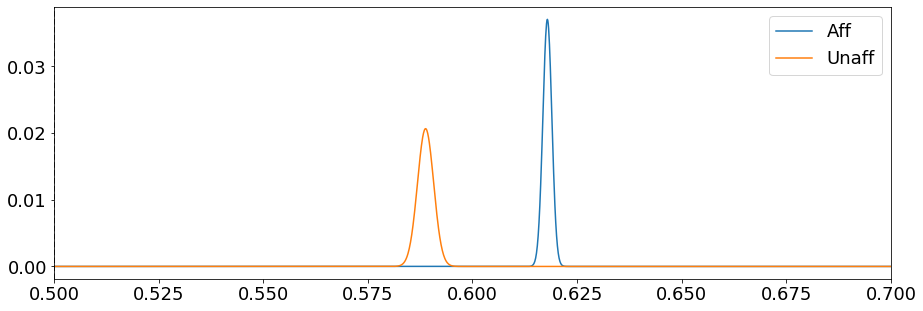

3.3042802166762364e-22


In [247]:
print(ps, diff)
plt.figure(figsize=(15, 5))
labels = ['Aff', 'Unaff']
for i in range(2):
    plt.plot(grid, posteriors[:, i], label=labels[i])
plt.xlim([0.5, 0.7])
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.show()

print(np.sum(np.minimum(posteriors[:, 0], posteriors[:, 1]))/np.sum(posteriors[:, 0]))


[0.61780544 0.58852168] 1


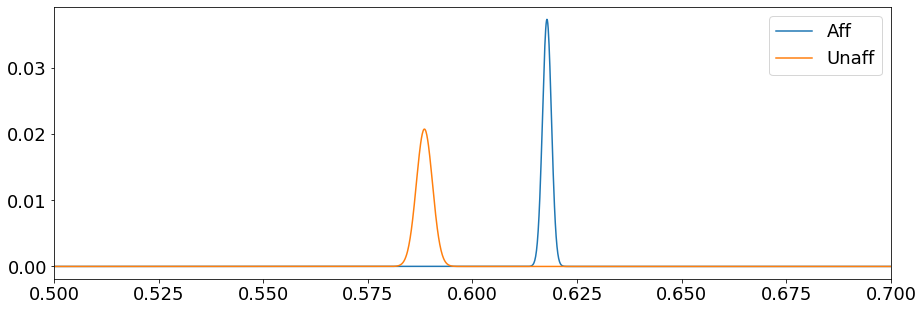

1.0273500199264461e-22


In [212]:
print(ps, diff)
plt.figure(figsize=(15, 5))
labels = ['Aff', 'Unaff']
for i in range(2):
    plt.plot(grid, posteriors[:, i], label=labels[i])
plt.xlim([0.5, 0.7])
plt.legend()
plt.show()

print(np.sum(np.minimum(posteriors[:, 0], posteriors[:, 1]))/np.sum(posteriors[:, 0]))


In [213]:
# deletion, AM/AF/UM/UF, notrans/trans
family_transmission = np.zeros((len(all_het_deletions), 2, 2), dtype=int)
for i, d in enumerate(all_het_deletions):
    if d['family_size'] == 4:
        family_transmission[i, 0, 0] = len([x for x in d['notrans'] if child_id_to_sex[x] == '1'])
        family_transmission[i, 0, 1] = len([x for x in d['trans'] if child_id_to_sex[x] == '1'])

        family_transmission[i, 1, 0] = len([x for x in d['notrans'] if child_id_to_sex[x] == '2'])
        family_transmission[i, 1, 1] = len([x for x in d['trans'] if child_id_to_sex[x] == '2'])

vs, cs = np.unique(family_transmission, axis=0, return_counts=True)
print(np.sum(np.any(family_transmission > 0, axis=(1, 2))))

family_transmission = np.zeros((len(all_doublehet_deletions), 2, 2), dtype=int)
for i, d in enumerate(all_doublehet_deletions):
    family_transmission[i, 0, 0] = len([x for x in d['notrans'] if child_id_to_sex[x] == '1'])
    family_transmission[i, 0, 1] = len([x for x in d['trans'] if child_id_to_sex[x] == '1'])

    family_transmission[i, 1, 0] = len([x for x in d['notrans'] if child_id_to_sex[x] == '2'])
    family_transmission[i, 1, 1] = len([x for x in d['trans'] if child_id_to_sex[x] == '2'])

#doublehet_vs, doublehet_cs = np.unique(family_transmission, axis=0, return_counts=True)
doublehet_vs, doublehet_cs = None, None
print(np.sum(np.any(family_transmission > 0, axis=(1, 2))))

posteriors, ps, diff = estimate_transmission(vs, cs, doublehet_vs, doublehet_cs, max_iters=1)

94954
0


[0.62293316 0.60046136] 1


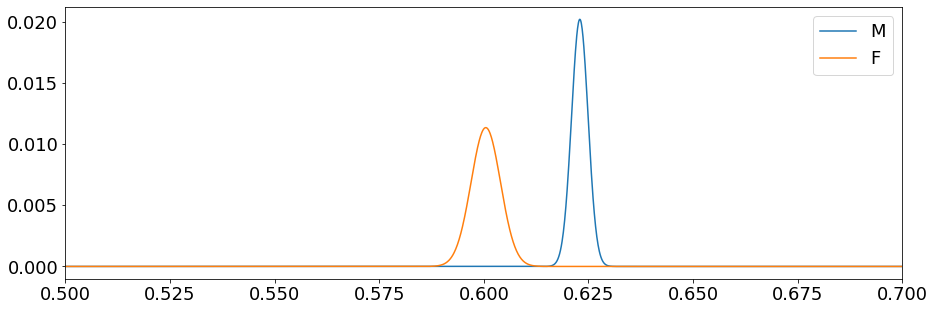

4.138242769953314e-05


In [214]:
print(ps, diff)
plt.figure(figsize=(15, 5))
labels = ['M', 'F']
for i in range(2):
    plt.plot(grid, posteriors[:, i], label=labels[i])
plt.xlim([0.5, 0.7])
plt.legend()
plt.show()

print(np.sum(np.minimum(posteriors[:, 0], posteriors[:, 1]))/np.sum(posteriors[:, 0]))
